Import Required Lbraries

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

Load and Prepare Dataset

In [2]:
# Set the path to your dataset folder
dataset_folder = 'D:/R001/cell_images'

In [3]:
# List of image paths and their respective labels
infected_image_paths = glob(os.path.join(dataset_folder, "infected", "*.png"))  # Adjust file extension if needed
uninfected_image_paths = glob(os.path.join(dataset_folder, "uninfected", "*.png"))  # Adjust file extension if needed

In [4]:
# Combine the two lists
image_paths = infected_image_paths + uninfected_image_paths

In [5]:
# Create labels: 1 for infected, 0 for uninfected
labels = [1] * len(infected_image_paths) + [0] * len(uninfected_image_paths)

In [6]:
# Convert to numpy arrays
labels = np.array(labels)

In [7]:
# Load images and convert to arrays
image_data = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(64, 64))  # Resize images to 64x64
    img = img_to_array(img)
    image_data.append(img)

image_data = np.array(image_data)

In [8]:
# Normalize the image data to [0, 1]
image_data = image_data.astype('float32') / 255.0

In [9]:
# Check number of images and labels loaded
print(f"Total images loaded: {image_data.shape[0]}")
print(f"Total labels loaded: {labels.shape[0]}")

Total images loaded: 27558
Total labels loaded: 27558


Split the Data

In [10]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
# One-hot encode the labels for binary classification
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

CNN-LSTM Model

In [12]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # CNN for feature extraction
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    # Flatten the CNN output to feed into LSTM
    model.add(TimeDistributed(Flatten()))

    # LSTM for temporal sequence modeling
    model.add(LSTM(64, return_sequences=False, activation='tanh'))

    # Fully connected layer and output
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))  # Binary classification: infected/uninfected
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

Input Shape and Create Model

In [13]:
# Define input shape (1 timestep for each image, 64x64 size, 3 channels for RGB)
input_shape = (1, 64, 64, 3)  # One image as one timestep
num_classes = 2  # Infected or Uninfected

# Create the model
model = create_cnn_lstm_model(input_shape, num_classes)
model.summary()

C:\Users\Hamza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 1, 64, 64, 32)       │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 32, 32, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 1, 16, 16, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 1, 16, 16, 128)      │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 1, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 1, 8192)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       2,113,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,211,330 (8.44 MB)

 Trainable params: 2,211,330 (8.44 MB)

 Non-trainable params: 0 (0.00 B)

Train The Model

In [14]:
# Reshape the training, validation, and test data to add the timestep dimension
X_train = X_train.reshape(-1, 1, 64, 64, 3)
X_val = X_val.reshape(-1, 1, 64, 64, 3)
X_test = X_test.reshape(-1, 1, 64, 64, 3)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 103s 155ms/step - accuracy: 0.7454 - loss: 0.4784 - val_accuracy: 0.9523 - val_loss: 0.1522
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 111s 185ms/step - accuracy: 0.9529 - loss: 0.1554 - val_accuracy: 0.9490 - val_loss: 0.1674
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.9535 - loss: 0.1428 - val_accuracy: 0.9569 - val_loss: 0.1340
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 120s 199ms/step - accuracy: 0.9596 - loss: 0.1231 - val_accuracy: 0.9560 - val_loss: 0.1366
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 122s 202ms/step - accuracy: 0.9593 - loss: 0.1220 - val_accuracy: 0.9557 - val_loss: 0.1369
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 160s 231ms/step - accuracy: 0.9644 - loss: 0.1018 - val_accuracy: 0.9521 - val_loss: 0.1436
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 97s 161ms/step - accuracy: 0.9689 - loss: 0.0913 - val_accuracy: 0.9550 - val_loss: 0.1370
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 110s 182ms/step - accuracy: 0.9743 - 

Evalutate The Model

In [45]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9640 - loss: 0.4047


In [47]:
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

Test Accuracy: 95.98%
Test loss: 49.17%


In [48]:
# Evaluate the model on train data
train_loss, train_acc = model.evaluate(X_train, y_train)

#The notation e-06 is scientific notation. It means 2.2765×10−62.2765×10 −6 , which is equivalent to 0.0000022765.

603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 1.0000 - loss: 2.2765e-06


In [56]:
print(f'Train Accuracy: {train_acc * 100:.2f}%')
print(f'Train loss: {train_loss * 100:.2f}%')

Train Accuracy: 100.00%
Train loss: 0.00%


Plotting

Validation and Loss Accuracy

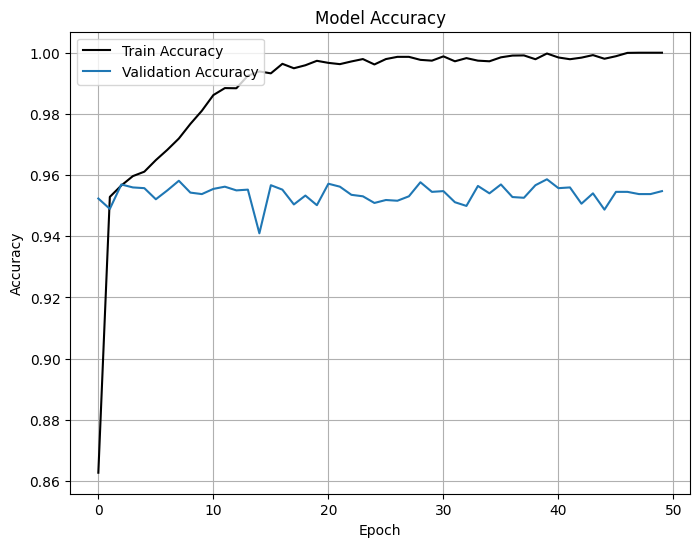

In [82]:
# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], color='black')
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.show()

plot_accuracy(history)


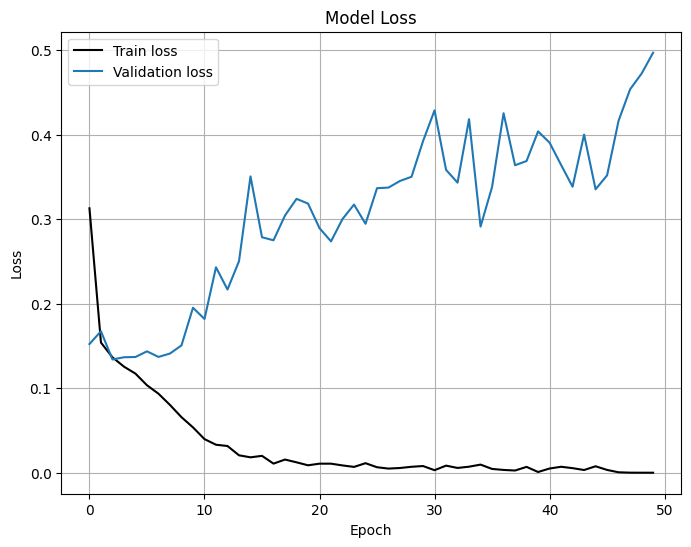

In [81]:
# Plot training & validation loss values
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], color='black')
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.grid()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper left')
    plt.show()

# Call the functions after training
plot_loss(history)

Confusion Matrix

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


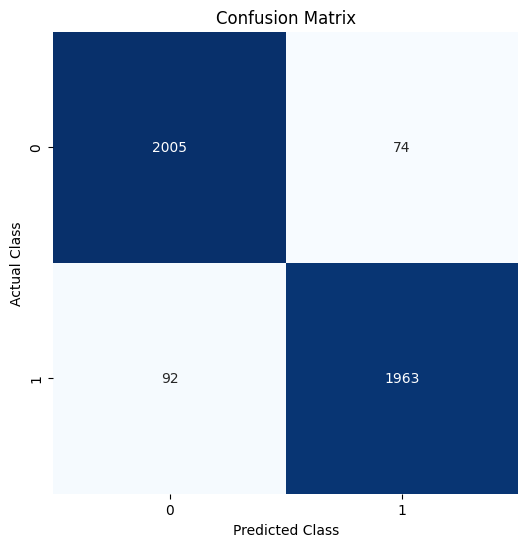

In [29]:
# Get predictions for the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded back to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels from one-hot encoded y_test

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(conf_matrix)

Classification report

In [31]:
# Generate the classification report
class_report = classification_report(y_true, y_pred_classes, target_names=['Uninfected', 'Infected'])

# Print the classification report
print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

  Uninfected       0.96      0.96      0.96      2079
    Infected       0.96      0.96      0.96      2055

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



Save and Load the Model

In [32]:
# Save the trained model
model.save('cnn_lstm_model50.keras')

In [9]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('cnn_lstm_model50.keras')

Preprocess User Input image

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Preprocessing function for a single input image
def preprocess_image(image_path, target_size=(64, 64)):
    # Load the image and resize it to the target size (64x64)
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = img_to_array(img)
    
    # Normalize the image data (same as in training)
    img_array = img_array.astype('float32') / 255.0
    
    # Reshape the image to match the model's input (1, 64, 64, 3), and add a time dimension
    img_array = img_array.reshape(1, 1, target_size[0], target_size[1], 3)
    
    return img_array

Predictions

In [ ]:
# Function to predict the class (infected or uninfected) of a given image
def predict_image_class(image_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Get the prediction from the model
    prediction = model.predict(preprocessed_image)
    
    # Decode the prediction (0 for uninfected, 1 for infected)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Returns 0 or 1
    class_label = 'Infected' if predicted_class == 1 else 'Uninfected'
    
    # Print the result
    print(f"The uploaded image is classified as: {class_label}")
    return class_label

User Input

In [36]:
# Example usage of the function to classify an image
image_path = '2.jpg'  # Replace with the actual image path
result = predict_image_class(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
The uploaded image is classified as: Infected


Predict and Show The Image

In [10]:
# Preprocess the image for the CNN-LSTM model
def preprocess_image(image_path, target_size=(64, 64)):
    # Load the image and resize it
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    
    # Normalize the image data (same as in training)
    img_array = img_array.astype('float32') / 255.0
    
    # Reshape the image to match the model's input (1, 64, 64, 3), and add time dimension
    img_array = img_array.reshape(1, 1, target_size[0], target_size[1], 3)
    return img_array, img

# Function to predict the class (infected or uninfected) of a given image and display the image
def predict_and_show_image(image_path):
    # Preprocess the image
    preprocessed_image, original_image = preprocess_image(image_path)
    
    # Get the prediction from the model
    prediction = model.predict(preprocessed_image)
    
    # Decode the prediction (0 for uninfected, 1 for infected)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Returns 0 or 1
    class_label = 'Infected' if predicted_class == 1 else 'Uninfected'
    
    # Display the image with the predicted class
    plt.figure(figsize=(4, 4))
    plt.imshow(original_image)
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted: {class_label}")
    plt.show()

    return class_label

User Input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


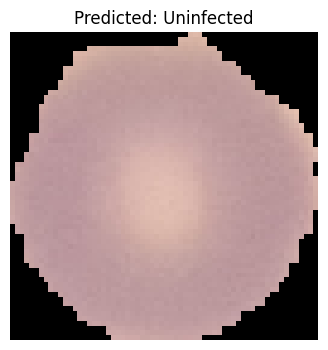

In [38]:
# Example usage with an image path
image_path = '001.png'  # Replace with the actual image path
result = predict_and_show_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


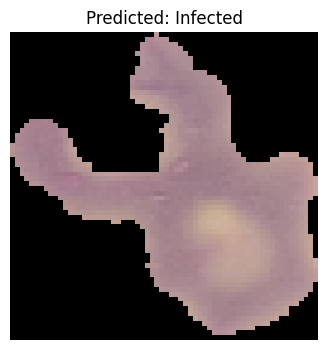

In [39]:
# Example usage with an image path
image_path = '002.png'  # Replace with the actual image path
result = predict_and_show_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


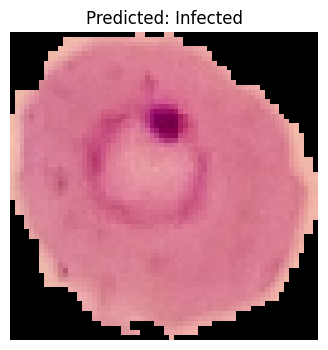

In [40]:
# Example usage with an image path
image_path = '3.png'  # Replace with the actual image path
result = predict_and_show_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


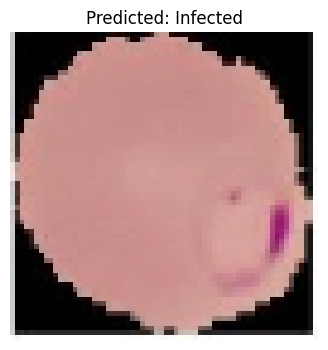

In [41]:
# Example usage with an image path
image_path = '2.jpg'  # Replace with the actual image path
result = predict_and_show_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


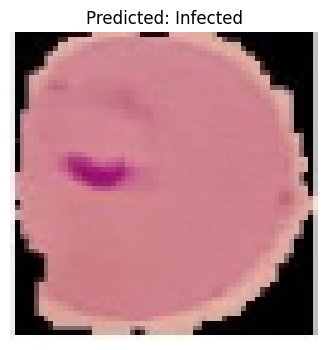

In [42]:
# Example usage with an image path
image_path = '1.jpg'  # Replace with the actual image path
result = predict_and_show_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


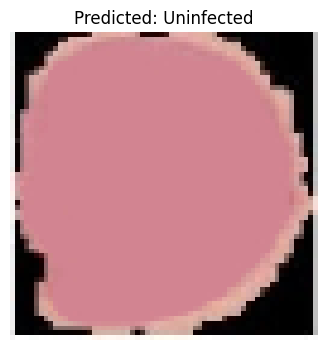

In [12]:
# Example usage with an image path
image_path = 'm2.jpg'  # Replace with the actual image path
result = predict_and_show_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


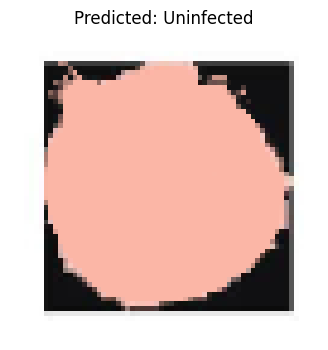

In [11]:
# Example usage with an image path
image_path = 'm1.jpg'  # Replace with the actual image path
result = predict_and_show_image(image_path)